In [28]:
import scipy
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Usuario\AppData\Local\Temp\ipykernel_2280\3641595917.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = scipy.io.wavfile.read("ash_16k.wav")


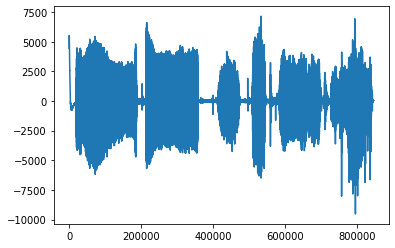

In [29]:
rate, data = scipy.io.wavfile.read("ash_16k.wav")
plt.plot(data)

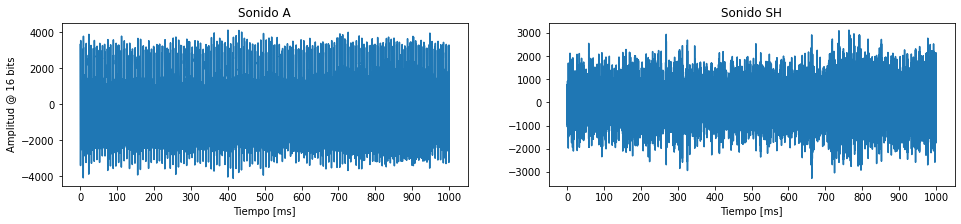

In [30]:
_, data_a = scipy.io.wavfile.read("a_16kHz.wav")
_, data_sh = scipy.io.wavfile.read("sh_16kHz.wav")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,3))
ax1.plot(data_a)
ax2.plot(data_sh)
ax1.set_title("Sonido A")
ax2.set_title("Sonido SH")
ax1.set_xlabel("Tiempo [ms]")
ax2.set_xlabel("Tiempo [ms]")
ax1.set_ylabel("Amplitud @ 16 bits")
#ax1.set_ylim(bottom=-1800, top=1800)
#ax2.set_ylim(bottom=-700, top=700)
ax1.set_xticks([1600*x for x in range(11)])
ax1.set_xticklabels([f"{100*x}" for x in range(11)])
ax2.set_xticks([1600*x for x in range(11)])
ax2.set_xticklabels([f"{100*x}" for x in range(11)])
plt.show()

In [31]:
print(f"mean(data_a) = {np.mean(data_a)}")
print(f"mean(data_sh) = {np.mean(data_sh)}")

mean(data_a) = 0.3005
mean(data_sh) = -3.4098125


In [63]:
def autocorrelation(data, N, L):
    x = data[:N]
    lags = [x for x in range(0, L)]
    rxx = scipy.signal.correlate(in1=x,in2=x, mode="full", method="fft") / N
    rxx = rxx[N-1: N+L-1]
    return lags, rxx

def plot_rxx(data, title, N=16000, L=500):
    lags, rxx = autocorrelation(data, N, L)
    fig = plt.figure(figsize=(8,3))
    plt.plot(lags, rxx)
    plt.ylabel(r"$r_{xx}(\tau)$", rotation=0, labelpad=10)
    plt.xlabel(r"$\tau$")
    plt.title(title)
    return fig

Se aprecia que la señal A es casi estacionaria dado que la autocorrelación es casi periódica.

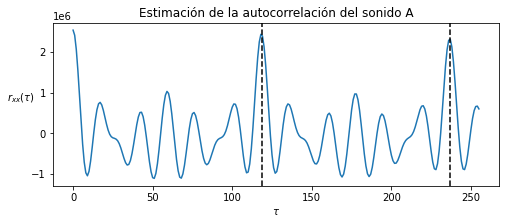

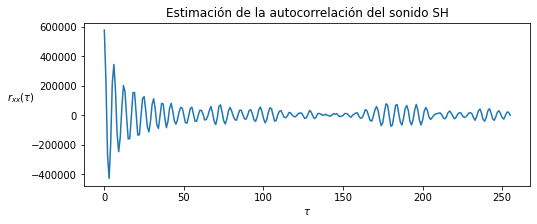

In [113]:
fig_rxx_a = plot_rxx(data_a - np.mean(data_a), "Estimación de la autocorrelación del sonido A", N=16000, L =256)
plt.axvline([119], c="k", linestyle="--")
plt.axvline([237], c="k", linestyle="--")
plt.show()

fig_rxx_sh = plot_rxx(data_sh - np.mean(data_sh), "Estimación de la autocorrelación del sonido SH", N=1600, L=256)
plt.show()

$\mathbf{R}(n) = E[\mathbf{x}(n)\mathbf{x}^H(n)]$

$\mathbf{r}^f(n) = E[\mathbf{x}(n-1){x}^*(n)]$

Ecuaciones normales:
$\mathbf{R}(n-1)\mathbf{a}_o(n) = -\mathbf{r}^f(n)$

MMSE:
$J_o^f = \sigma_x^2(n) + \mathbf{r}^{fH}(n)\mathbf{a}_o(n)$ 

In [199]:
def flp(data, M):
    data = data - np.mean(data)
    _, rxx = autocorrelation(data, N=16000, L=500)

    # Input data vector x=x(n-1)

    c=rxx[:M] # c = [r(0) ... r(M-1)]
    #R = scipy.linalg.toeplitz(c=c)
    rf = rxx[1:M+1] # rf = [r(1) ... r(M)]
    
    # Solve normal equations
    ao = scipy.linalg.solve_toeplitz(c_or_cr=c, b=-rf)
    Jo = rxx[0] + np.dot(np.array(rf), np.array(ao))

    results = dict(data=data, Jo=Jo, rf=rf, ao=ao)
    return results

In [200]:
def plot_mmse_vs_order(data, max_order, title, vlines):
    mmse = []
    order = [M for M in range(10,max_order+1,1)]
    for M in order:
        mmse.append(flp(data, M)["Jo"])

    fig = plt.figure(figsize=(12,5))
    for vline in vlines:
        plt.axvline([vline], c='k', linestyle="-.")
    plt.plot(order, mmse, '.')
    plt.title(title)
    plt.xlabel("Orden del predictor")
    plt.ylabel("MMSE")
    plt.xticks([M for M in range(10,max_order+1,10)])

    
    return fig

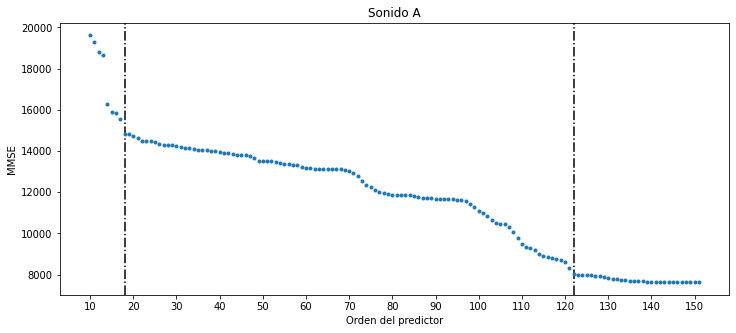

In [201]:
fig_a = plot_mmse_vs_order(data_a, 151, "Sonido A", vlines=[18,122])
plt.show()

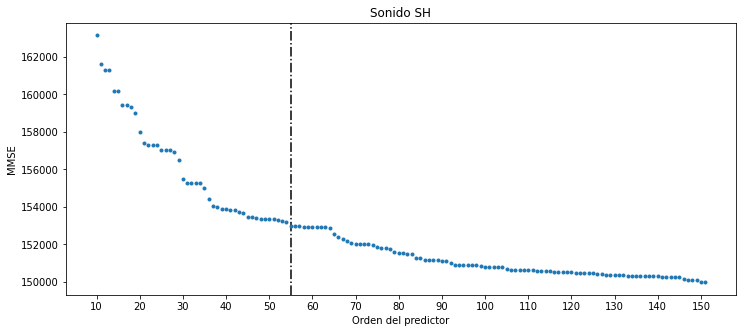

In [193]:
fig_sh = plot_mmse_vs_order(data_sh, 151, "Sonido SH", vlines=[55])
plt.show()

Filtro del error de predicción forward

In [248]:
def error(data, M):
    d = flp(data, M)
    fp_error_filter = np.concatenate(([1], d["ao"]))
    ef = np.convolve(data_a, fp_error_filter)[:16000]
    return ef

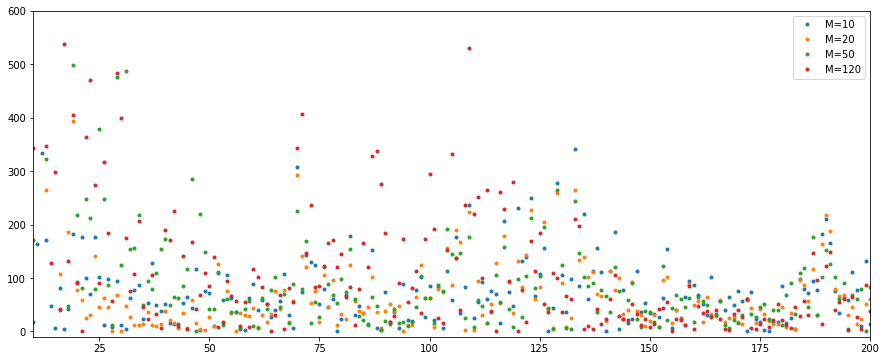

In [264]:
plt.figure(figsize=(15,6))
orders = [10, 20, 50, 120]
for M in orders:
    ef = error(data_a, M)
    plt.plot(np.abs(ef), '.')

plt.ylim((-10,600))
plt.xlim((10,200))
plt.legend([f"M={str(x)}" for x in orders])

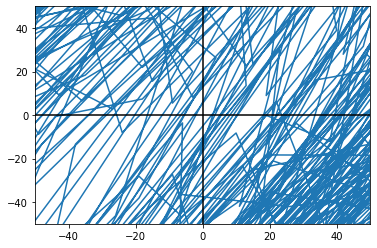

In [323]:
res = flp(data_a, 2)
y = data_a
y_est = np.convolve(y, -res["ao"])[:16000]
plt.plot(y, y_est)
plt.axvline([0], c="k")
plt.axhline([0], c="k")
plt.xlim((-50,50))
plt.ylim((-50,50))
plt.show()

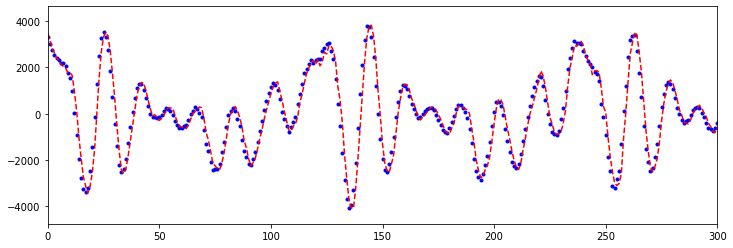

In [440]:
M = 120
y = data_a
res = flp(y, M)
ao = res["ao"]
wf = -ao
#print(f"ao = {ao}")
#print(f"wf = {wf}")

y_est = np.zeros(16000)
for i in range(M, 16000, 1):
    y_est[i] = np.dot(y[i-M:i][::-1], wf)

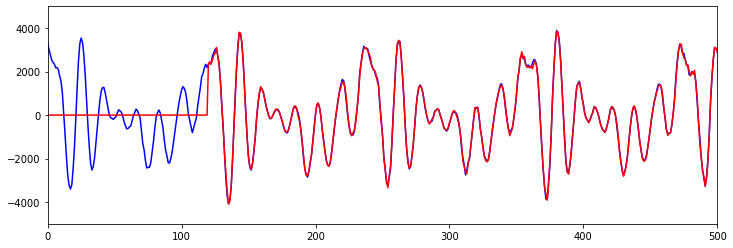

In [441]:
plt.figure(figsize=(12,4))
plt.plot(y, 'b')
plt.plot(y_est, 'r')
plt.xlim((0,500))
plt.ylim((-5000,5000))
plt.show()

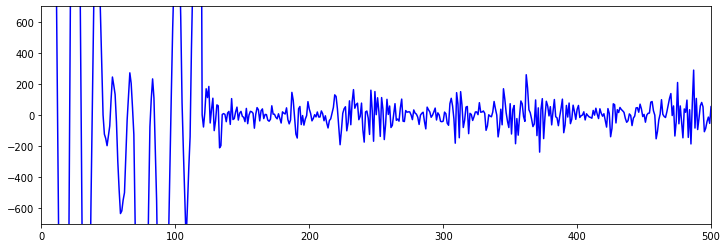

In [442]:
plt.figure(figsize=(12,4))
plt.plot(y- y_est, 'b')
plt.xlim((0,500))
plt.ylim((-700,700))
plt.show()